Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Training Pipeline
---
This notebook demonstrates how to create a pipeline that trains, scores, and registers many models. We utilize the [ParallelRunStep](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-parallel-run-step) to parallelize the process of training the models to make the process more efficient. For this solution accelerator we are using the [OJ Sales Dataset](https://azure.microsoft.com/en-us/services/open-datasets/catalog/sample-oj-sales-simulated/) to train individual models that predict sales for each store and brand of orange juice.


### Prerequisites
At this point, you should have already:

1. Created your AML Workspace using the [00_Setup_AML_Workspace notebook](../00_Setup_AML_Workspace.ipynb)
2. Run [01_Data_Preparation.ipynb](01_Data_Preparation.ipynb) to setup your compute and create the dataset

## 1.0 Connect to workspace and datastore

In [1]:
from azureml.core import Workspace

# set up workspace
ws = Workspace.from_config()

# set up datastores
dstore = ws.get_default_datastore()

print('Workspace Name: ' + ws.name, 
      'Azure Region: ' + ws.location, 
      'Subscription Id: ' + ws.subscription_id, 
      'Resource Group: ' + ws.resource_group, 
      sep = '\n')

Workspace Name: erwrightDevTest
Azure Region: westus2
Subscription Id: 381b38e9-9840-4719-a5a0-61d9585e1e91
Resource Group: erwright-automl


## 2.0 Create an experiment

In [2]:
from azureml.core import Experiment

experiment = Experiment(ws, 'oj_training_pipeline')

print('Experiment name: ' + experiment.name)

Experiment name: oj_training_pipeline


## 3.0 Get the dataset
Next, we get the dataset we created in the last step using the [Dataset.get_by_name()](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.dataset.dataset?view=azure-ml-py#get-by-name-workspace--name--version--latest--) method.

In [3]:
from azureml.core.dataset import Dataset

dataset_name = 'oj_data_small_train'
small_dataset = Dataset.get_by_name(ws, name=dataset_name)
small_dataset_input = small_dataset.as_named_input(dataset_name)

## 4.0 Create the training pipeline
Now that the workspace, experiment, and dataset are set up, we can put together a pipeline for training.

### 4.1 Configure environment for ParallelRunStep
An [environment](https://docs.microsoft.com/en-us/azure/machine-learning/concept-environments) defines a collection of resources that we will need to run our pipelines. We configure a reproducible Python environment for our training script including the [scikit-learn](https://scikit-learn.org/stable/index.html) python library.

In [4]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

train_env = Environment(name="many_models_environment")
train_conda_deps = CondaDependencies.create(pip_packages=['sklearn', 'joblib'])
train_env.python.conda_dependencies = train_conda_deps

### 4.2 Choose a compute target 

In [5]:
from azureml.core.compute import AmlCompute

compute = AmlCompute(ws, "cpucluster")

### 4.3 Set up ParallelRunConfig

[ParallelRunConfig](https://docs.microsoft.com/en-us/python/api/azureml-contrib-pipeline-steps/azureml.contrib.pipeline.steps.parallel_run_config.parallelrunconfig?view=azure-ml-py) provides the configuration for the ParallelRunStep we'll be creating next. Here we specify the environment and compute target we created above along with the entry script that will be for each batch.

There's a number of important parameters to configure including:
- **mini_batch_size**: The number of files per batch. If you have 500 files and mini_batch_size is 10, 50 batches would be created containing 10 files each. Batches are split across the various nodes. 

- **node_count**: The number of compute nodes to be used for running the user script. We recommend to start with 5 and increasing the node_count from there. If you increase the node count here, you'll need to increase the max_nodes for the compute cluster as well.

- **process_count_per_node**: The number of processes per node. The compute cluster we are using has 8 cores so we set this parameter to 8.

- **run_invocation_timeout**: The run() method invocation timeout in seconds. The timeout should be set to be higher than the maximum training time of one model (in seconds), by default it's 60. Since the batches that takes the longest to train are about 120 seconds, we set it to be 180 to ensure the method has adequate time to run.


We also added tags to preserve the information about our training cluster's node count, process count per node, and dataset name. You can find the 'Tags' column in Azure Machine Learning Studio.

In [6]:
from azureml.contrib.pipeline.steps import ParallelRunConfig

processes_per_node = 6
node_count = 1
timeout = 180

tags = {}
tags['dataset_name'] = dataset_name
tags['node_count'] = node_count
tags['process_count_per_node'] = processes_per_node
tags['timeout'] = timeout

parallel_run_config = ParallelRunConfig(
    source_directory='./scripts',
    entry_script='train.py',
    mini_batch_size="1",
    run_invocation_timeout=timeout,
    error_threshold=10,
    output_action="append_row",
    environment=train_env,
    process_count_per_node=processes_per_node,
    compute_target=compute,
    node_count=node_count)

### 4.4 Set up ParallelRunStep

This [ParallelRunStep](https://docs.microsoft.com/en-us/python/api/azureml-contrib-pipeline-steps/azureml.contrib.pipeline.steps.parallelrunstep?view=azure-ml-py) is the main step in our training pipeline. 

First, we set up the output directory and define the pipeline's output name. The datastore that stores the pipeline's output data is Workspace's default datastore.

In [7]:
from azureml.pipeline.core import PipelineData

output_dir = PipelineData(name="training_output", datastore=dstore)

We provide our ParallelRunStep with a name, the ParallelRunConfig created above and several other parameters:

- **inputs**: A list of input datasets. Here we'll use the dataset created in the previous notebook. The number of files in that path determines the number of models will be trained in the ParallelRunStep.

- **output**: A PipelineData object that corresponds to the output directory. We'll use the output directory we just defined. 

- **arguments**: A list of arguments required for the train.py entry script.

In [8]:
from azureml.contrib.pipeline.steps import ParallelRunStep

parallel_run_step = ParallelRunStep(
    name="many-models-training",
    parallel_run_config=parallel_run_config,
    inputs=[small_dataset_input],
    output=output_dir,
    allow_reuse=False,
    arguments=['--target_column', 'Quantity', 
               '--timestamp_column', 'WeekStarting', 
               '--timeseries_id_columns', 'Store', 'Brand',
               '--drop_columns', 'Revenue', 'Store', 'Brand',
               '--model_type', 'lr'])

## 5.0 Run the pipeline
Next, we submit our pipeline to run. With 10 files, this should only take a few minutes but with the full dataset this can take over an hour.

In [9]:
from azureml.pipeline.core import Pipeline
#from azureml.widgets import RunDetails

pipeline = Pipeline(workspace=ws, steps=[parallel_run_step])
run = experiment.submit(pipeline,tags=tags)
#RunDetails(run).show()

Created step many-models-training [7f85061f][34bdefe3-e44c-4dd9-9e46-d550b911d193], (This step will run and generate new outputs)
Using data reference oj_data_small_train_0 for StepId [69d7a829][956eaa4e-3d0e-4e75-b490-baea89fdc454], (Consumers of this data are eligible to reuse prior runs.)
Submitted PipelineRun 568dd024-0447-4d8e-9a70-1d8fc87fa3bb


WARNING - Converting non-string tag to string: (node_count: 1)
WARNING - Converting non-string tag to string: (process_count_per_node: 6)
WARNING - Converting non-string tag to string: (timeout: 180)


Link to Azure Machine Learning Portal: https://ml.azure.com/experiments/oj_training_pipeline/runs/568dd024-0447-4d8e-9a70-1d8fc87fa3bb?wsid=/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/erwright-automl/workspaces/erwrightDevTest


## 6.0 View results of training pipeline
The dataframe we return in the run method of train.py is outputted to *parallel_run_step.txt*. To see the results of our training pipeline, we'll download that file, read in the data to a DataFrame, and then visualize the results
The run submitted to the Azure Machine Learning Training Compute Cluster may take a while. The output is not generated until the run is complete. You can monitor the status of the run in Azure Portal https://ml.azure.com

### 6.1 Download parallel_run_step.txt locally

In [10]:
import os

def download_results(run, target_dir=None):
    stitch_run = run.find_step_run("many-models-training")[0]
    port_data = stitch_run.get_output_data("training_output")
    print(port_data)
    port_data.download(target_dir, show_progress=True)
    step_hash = os.listdir(os.path.join(target_dir, 'azureml'))[0]
    return  os.path.join(target_dir, 'azureml', step_hash, 'training_output')

file_path = download_results(run, 'output')
file_path

$AZUREML_DATAREFERENCE_training_output
Downloaded azureml/abe804cf-f43f-46d8-9a01-b032ba836f00/training_output/parallel_run_step.txt, 1 files out of an estimated total of 1


'output\\azureml\\abe804cf-f43f-46d8-9a01-b032ba836f00\\training_output'

### 6.2 Convert the file to a dataframe

In [11]:
import pandas as pd

df = pd.read_csv(file_path + '/parallel_run_step.txt', sep=" ", header=None)
df.columns = ['Store', 'Brand', 'Model', 'File Name', 'ModelName', 'StartTime', 'EndTime', 'Duration', 'MSE','RMSE', 'MAE', 'MAPE', 'Index', 'Number of Models', 'Status']

df['StartTime'] = pd.to_datetime(df['StartTime'])
df['EndTime'] = pd.to_datetime(df['EndTime'])
df['Duration'] = df['EndTime'] - df['StartTime']
df.head()

,Store,Brand,Model,File Name,ModelName,StartTime,EndTime,Duration,MSE,RMSE,MAE,MAPE,Index,Number of Models,Status
0,1000,tropicana,lr,Store1000_tropicana,lr_Store1000_tropicana,2020-06-18 21:40:40.619420,2020-06-18 21:40:44.198653,00:00:03.579233,9.425532e+06,3070.102939,2646.246390,19.605438,0,1,Running
1,1000,minute.maid,lr,Store1000_minute.maid,lr_Store1000_minute.maid,2020-06-18 21:40:40.336794,2020-06-18 21:40:41.644305,00:00:01.307511,9.417040e+06,3068.719637,2586.090572,19.239648,0,1,Running
2,1001,tropicana,lr,Store1001_tropicana,lr_Store1001_tropicana,2020-06-18 21:40:40.230998,2020-06-18 21:40:41.450524,00:00:01.219526,8.270064e+06,2875.771840,2396.744121,17.807357,0,1,Running
3,1002,tropicana,lr,Store1002_tropicana,lr_Store1002_tropicana,2020-06-18 21:40:41.699160,2020-06-18 21:40:42.743323,00:00:01.044163,9.007828e+06,3001.304331,2582.515593,18.976866,0,1,Running
4,1001,dominicks,lr,Store1001_dominicks,lr_Store1001_dominicks,2020-06-18 21:40:39.345339,2020-06-18 21:40:40.505579,00:00:01.160240,8.170958e+06,2858.488714,2426.815548,17.446638,0,1,Running


### 6.3 Review Results

In [12]:
total = df['EndTime'].max()  - df['StartTime'].min()

print('Number of Models: ' + str(len(df)))
print('Total Duration: ' + str(total)[6:])

Number of Models: 10
Total Duration:  00:00:05.635253


In [13]:
print('Average MAPE: ' + str(round(df['MAPE'].mean(), 5)))
print('Average MSE: ' + str(round(df['MSE'].mean(), 5)))
print('Average RMSE: ' + str(round(df['RMSE'].mean(), 5)))
print('Average MAE: '+ str(round(df['MAE'].mean(), 5)))

Average MAPE: 19.39532
Average MSE: 9424154.18888
Average RMSE: 3066.94014
Average MAE: 2611.5952


In [14]:
print('Maximum Duration: '+ str(df['Duration'].max())[7:])
print('Minimum Duration: ' + str(df['Duration'].min())[7:])
print('Average Duration: ' + str(df['Duration'].mean())[7:])

Maximum Duration: 00:00:03.579233
Minimum Duration: 00:00:00.882331
Average Duration: 00:00:01.409898


### 6.4 Visualize Performance across models

First we look at the RMSE across all models: 

In [15]:
import seaborn as sns 
import matplotlib.pyplot as plt

fig = sns.violinplot(y=df['RMSE'], data=df)
fig.set_title('RMSE across all models')

ModuleNotFoundError: No module named 'seaborn'

Next, we can break that down by Brand or Store to see variations in error across our models

In [ ]:
fig = sns.violinplot(x=df['Brand'], y=df['RMSE'], data=df)
fig.set_title('RMSE by Brand')

We can also look at how long models for different brands took to train

NameError: name 'plt' is not defined

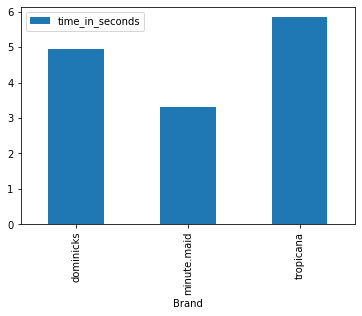

In [16]:
brand = df.groupby('Brand')
brand = brand['Duration'].sum()
brand = pd.DataFrame(brand)
brand['time_in_seconds'] = [time.total_seconds()  for time in brand['Duration']]

brand.drop(columns=['Duration']).plot(kind='bar')
plt.xlabel('Brand')
plt.ylabel('Seconds')
plt.title('Total Training Time by Brand')
plt.show()

## 7.0 Publish and schedule the pipeline (Optional)


### 7.1 Publish the pipeline
Once you have a pipeline you're happy with, you can publish a pipeline so you can call it programatically later on. See this [tutorial](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-create-your-first-pipeline#publish-a-pipeline) for additional information on publishing and calling pipelines.

In [ ]:
# published_pipeline = pipeline.publish(name = 'train_many_models',
#                                      description = 'train many models',
#                                      version = '1',
#                                      continue_on_step_failure = False)

### 7.2 Schedule the pipeline
You can also [schedule the pipeline](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-schedule-pipelines) to run on a time-based or change-based schedule. This could be used to automatically retrain models every month or based on another trigger such as data drift.

In [ ]:
# from azureml.pipeline.core import Schedule, ScheduleRecurrence
    
# training_pipeline_id = published_pipeline.id

# recurrence = ScheduleRecurrence(frequency="Month", interval=1, start_time="2020-01-01T09:00:00")
# recurring_schedule = Schedule.create(ws, name="training_pipeline_recurring_schedule", 
#                             description="Schedule Training Pipeline to run on the first day of every month",
#                             pipeline_id=training_pipeline_id, 
#                             experiment_name=experiment.name, 
#                             recurrence=recurrence)

Now that you've trained and scored the models, move on to 03_Forecasting_Pipeline.ipynb to make forecasts with your models.